In [10]:
import boto3
from datetime import datetime
import matplotlib.pyplot as plt
import mercantile
import numpy as np
import pandas as pd
from rio_tiler.io import cogeo

In [2]:
# Configuration of S3
s3 = boto3.resource('s3')

In [4]:
# Regions of interest
# NASA Covid Dashboard Supersites
beijing = dict(lat=39.916668, lon=116.383331)
la = dict(lat=34.05, lon=-118.25)
new_york = dict(lat=40.661, lon=-73.944)
san_fran = dict(lat=37.7775, lon=-122.416389)
tokyo = dict(lat=35.689722, lon=139.692222)
latlons = dict(
    beijing=beijing,
    los_angeles=la,
    new_york=new_york,
    san_fran=san_fran,
    tokyo=tokyo
)

In [6]:
# Collection configuration
buckets = dict(no2='omi-no2-nasa', aod='modis-aod-nasa', vi='modis-vi-nasa')
nodata_values = dict(no2=-1.26765060000000006e+30, aod=-28672, vi=-3000)

modis_dates = {
    'MOD13A2.006': { 2018: [], 2019: [], 2020: [] },
    'MYD13A2.006': { 2018: [], 2019: [], 2020: [] }
}

# MODIS VI data is every 16 days, so create a dictionary of dates for looking up the nearest date
modis_vi_bucket = s3.Bucket(buckets['vi'])
for year in range(2018, 2021):
    for collection in modis_dates.keys():
        for tif in list(modis_vi_bucket.objects.filter(Prefix=f'{collection}/{year}')):
            date = datetime.strptime(tif.key, f'{collection}/%Y.%m.%d.tif')
            modis_dates[collection][year].append(date)

In [7]:
# Helper functions

def city_title(city_key):
    return ' '.join(city_key.split('_')).title()
    
def nearest(items, pivot):
    """
    Return the nearest item to 'pivot' from a list of items
    Used to find the nearest date from MODIS VI collections
    """
    return min(items, key=lambda x: abs(x - pivot))    

def get_tile_url(opts={}):
    collection = opts.get('collection')
    date = opts.get('date')
    bucket_name = buckets[collection]
    bucket = s3.Bucket(bucket_name)
    if collection == 'no2':
        tif_url_prefix = f'OMI-Aura_L3-OMNO2d_{date.year}m{date.month:02}{date.day:02}'
        tif = list(bucket.objects.filter(Prefix=tif_url_prefix))[0]
        tile_url = f's3://{bucket_name}/{tif.key}'
    elif collection == 'aod':
        tile_url = f's3://{bucket_name}/{date.year}.{date.month:02}.{date.day:02}.tif'
    elif collection == 'vi':
        # VI is every 16 days, so return the closest day
        closest_terra_day = nearest(modis_dates['MOD13A2.006'][date.year], date)
        closest_aqua_day = nearest(modis_dates['MYD13A2.006'][date.year], date)
        if abs(date - closest_terra_day) < abs(date - closest_aqua_day):
            nearest_date = closest_terra_day
            vi_collection = 'MOD13A2.006'
        else:
            nearest_date = closest_aqua_day
            vi_collection = 'MYD13A2.006'
        tile_url = f's3://{bucket_name}/{vi_collection}/{nearest_date.year}.{nearest_date.month:02}.{nearest_date.day:02}.tif'
    return tile_url

In [8]:
def get_city_tile(opts={}):
    """ Return tile for city on date """
    city = opts.get('city')
    zoom = opts.get('zoom')
    city_tile = mercantile.tile(latlons[city]['lon'], latlons[city]['lat'], zoom)
    tile_url = get_tile_url(opts)
    tile, mask = cogeo.tile(
        tile_url,
        city_tile.x,  # mercator tile X value (arbitrary map tile location within the source image)
        city_tile.y,  # mercator tile Y value
        zoom,  # mercator tile Z value
        tilesize=256
    )
    return tile

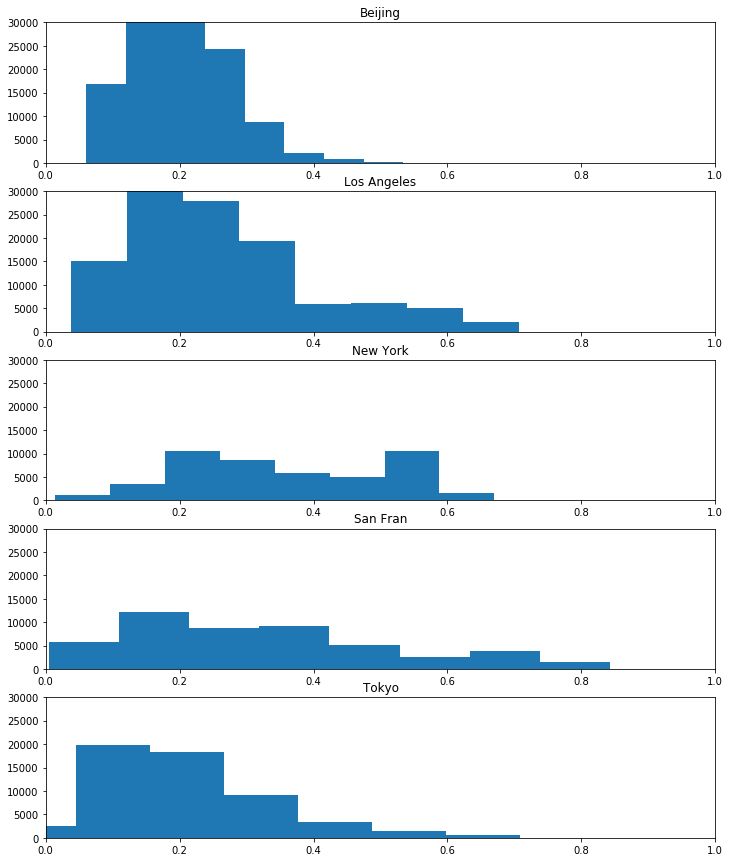

In [11]:
# Plot a histogram of NO2 for each city on a given day
date = datetime(2020, 4, 1)
plt.rcParams["figure.figsize"] = (12, 15)
fig, axs = plt.subplots(5)
variable = 'vi'
zoom = 10
for idx, city in enumerate(latlons.keys()):
    tile = get_city_tile(dict(collection=variable, date=date, zoom=zoom, city=city))    
    data = tile[tile != nodata_values[variable]]
    axis = axs[idx]
    axis.hist(data, bins=8)
    axis.set_title(city_title(city))
    axis.set_ylim(0, 30000)
    axis.set_xlim(0, 1)


In [16]:
%%time

# Plot a timeseries of aod values
years = [2020, 2019, 2018]
variable = 'aod'
city = 'los_angeles'
zoom = 8
values = {}
for year in years:
    dates = pd.date_range(datetime(year, 1, 1), datetime(year, 5, 26), freq='5d')
    values[year] = {'dates': [], 'values': []}
    for date in dates:
        tile = get_city_tile(dict(collection=variable, date=date, zoom=zoom, city=city))
        values[year]['dates'].append(date)
        values[year]['values'].append(np.median(tile[tile != nodata_values[variable]]))

CPU times: user 3.99 s, sys: 653 ms, total: 4.65 s
Wall time: 2min 24s


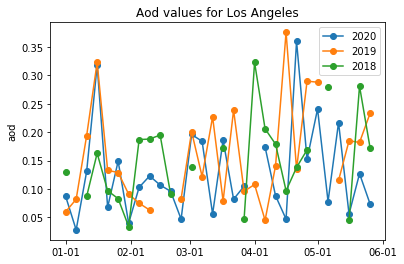

In [17]:
%matplotlib inline
import matplotlib.dates as mdates

month_fmt = mdates.DateFormatter('%m-%d')
fig, ax = plt.subplots()
x = values[2018]['dates']

for idx, year in enumerate(years):
    y = values[year]['values']
    ax.plot(x, y, 'o-', label=str(year))

# format the ticks
ax.xaxis.set_major_formatter(month_fmt)

plt.title(f'{variable.title()} values for {city_title(city)}')
plt.ylabel(variable)
plt.legend()
plt.show()

In [25]:
from mapboxgl.viz import RasterTilesViz

# Set Mapbox Acces Token; Must be a public token, starting with `pk`
token = 'pk.eyJ1IjoiYWltZWViIiwiYSI6ImNqZjVwNXMwNzExY3gycW44dGdyenFxaGoifQ.jd1Kgk4V2276G97KKcXZBA'
city = 'san_fran'
zoom = 5
tile_url = get_tile_url(dict(collection='aod', date=datetime(2018, 4, 24), zoom=zoom, city=city))
tiles_url = "https://pfg2k5mjei.execute-api.us-west-2.amazonaws.com/v1/{z}/{x}/{y}@1x?" + \
  f"url={tile_url}&resampling_method=bilinear&bidx=1&rescale=0,1" + \
  "&resampling_method=bilinear"

tiles_bounds = [-180, -90, 180, 90]
viz = RasterTilesViz(tiles_url, 
                     access_token=token,
                     tiles_size=256,
                     tiles_bounds=tiles_bounds,
                     height='600px',
                     width='900px',
                     center=tiles_center,
                     tiles_minzoom=0,
                     tiles_maxzoom=18,
                     zoom=zoom,
                     below_layer='waterway-label')
viz.show()